In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys

# Precinct Shapefile

## VEST's Documentation File

## Election Results

Election results are from Oklahoma State Election Board (https://results.okelections.us/OKER/?elecDate=20201103).

## Shape Files
Precinct shapefile from Oklahoma GIS Data Warehouse (https://csagis-uok.opendata.arcgis.com/).

RDH note: shapefile for GIS data warehouse here: https://csagis-uok.opendata.arcgis.com/datasets/c83b09af406d48f7bbca30942fe186a8_0/explore?location=35.317799%2C-98.716567%2C8.77

## Processing
Early votes were reported countywide for Oklahoma County and Tulsa County. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

## Races

- G20PRERTRU - Donald J. Trump (Republican Party) 
- G20PREDBID - Joseph R. Biden (Democratic Party) 
- G20PRELJOR - Jo Jorgensen (Libertarian Party)
- G20PREIWES - Kanye West (Independent)
- G20PREISIM - Jade Simmons (Independent)
- G20PREIPIE - Brock Pierce (Independent)
- G20USSRINH - Jim Inhofe (Republican Party)
- G20USSDBRO - Abby Broyles (Democratic Party)
- G20USSLMUR - Robert Murphy (Libertarian Party)
- G20USSIFAR - Joan Farr (Independent)
- G20USSINES - A.D. Nesbit (Independent)
- G20COCRHIE - Todd Hiett (Republican Party)
- G20COCLHAG - Todd Hagopian (Libertarian Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("raw-from-source/VEST/ok_2020/ok_2020.shp")

In [3]:
vest_shp.shape

(1948, 19)

In [4]:
vest_shp.head()


,STATEFP,COUNTYFP,COUNTY_NAM,PCT_CEB,GEOID,G20PRERTRU,G20PREDBID,G20PRELJOR,G20PREIWES,G20PREISIM,G20PREIPIE,G20USSRINH,G20USSDBRO,G20USSLMUR,G20USSIFAR,G20USSINES,G20COCRHIE,G20COCLHAG,geometry
0,40,063,Hughes,320010,40063320010,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-96.31855 35.02881, -96.31878 35.028..."
1,40,143,Tulsa,720175,40143720175,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-95.92251 36.18026, -95.92256 36.180..."
2,40,109,Oklahoma,550256,40109550256,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-97.65129 35.72594, -97.65083 35.725..."
3,40,017,Canadian,090399,40017090399,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-97.77765 35.38274, -97.77764 35.386..."
4,40,143,Tulsa,720174,40143720174,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-95.92526 36.17711, -95.92585 36.177..."


<AxesSubplot:>

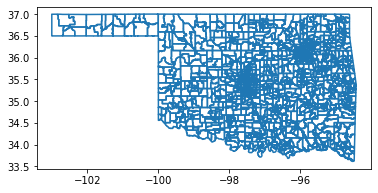

In [5]:
vest_shp.boundary.plot()

<AxesSubplot:>

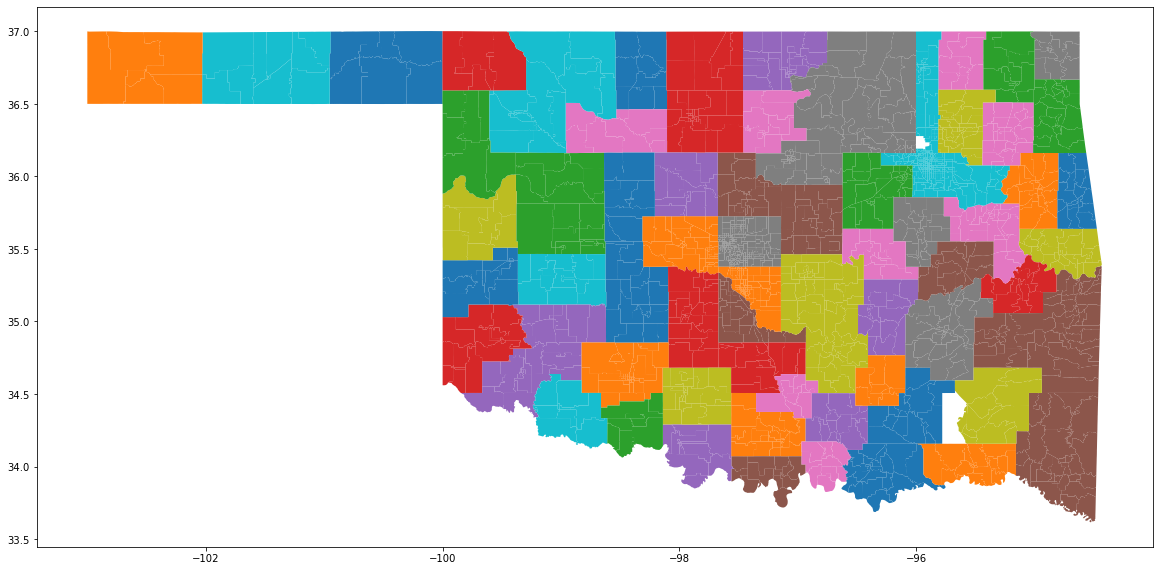

In [6]:
vest_shp.plot(column='COUNTYFP', figsize=(20,20))
#missing two counties

<AxesSubplot:>

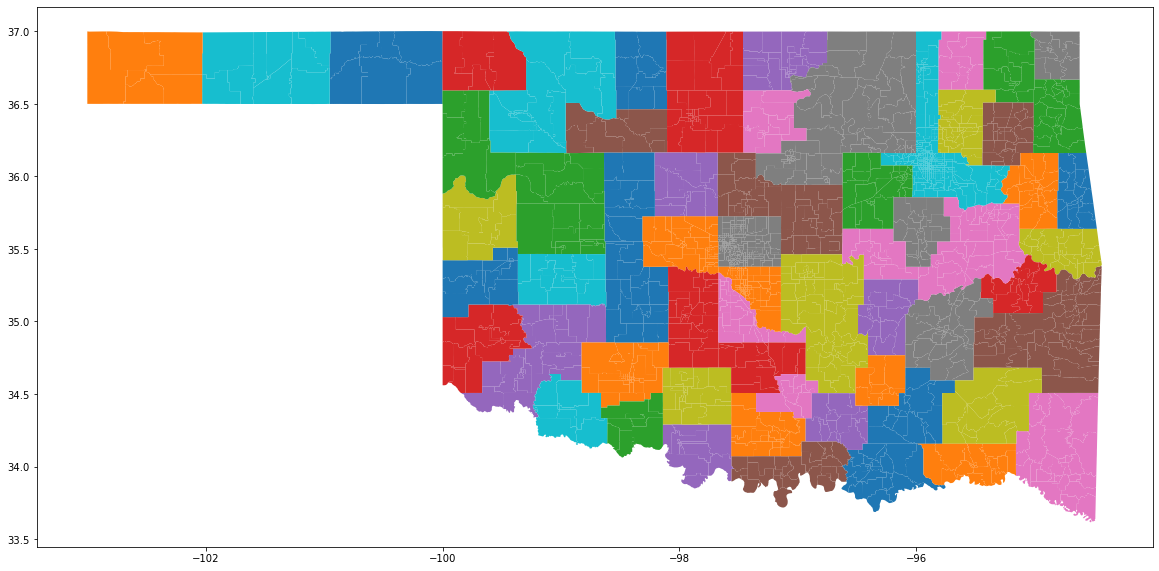

In [7]:
vest_shp.plot(column='COUNTY_NAM', figsize=(20,20))

In [8]:
vest_shp.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTY_NAM', 'PCT_CEB', 'GEOID', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREIWES', 'G20PREISIM', 'G20PREIPIE',
       'G20USSRINH', 'G20USSDBRO', 'G20USSLMUR', 'G20USSIFAR', 'G20USSINES',
       'G20COCRHIE', 'G20COCLHAG', 'geometry'],
      dtype='object')

## Load the SOS Election Results File

In [9]:
ok_20 = pd.read_csv("raw-from-source/precinct_results/20201103_PrecinctResults.csv", index_col=False)

In [10]:
ok_20.head()

,elec_date,precinct,entity_description,race_number,race_description,race_party,tot_race_prec,race_prec_reporting,cand_number,cand_name,cand_party,cand_absmail_votes,cand_early_votes,cand_elecday_votes,cand_tot_votes,race_county_owner
0,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,1,DONALD J. TRUMP | MICHAEL R. PENCE,REP,16,43,219,278,NaN
1,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,2,JO JORGENSEN | JEREMY SPIKE COHEN,LIB,2,0,3,5,NaN
2,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,3,JOSEPH R. BIDEN | KAMALA D. HARRIS,DEM,5,7,53,65,NaN
3,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,4,JADE SIMMONS | CLAUDELIAH J. ROZE,IND,0,0,3,3,NaN
4,11/3/2020,10001,"FEDERAL, STATE AND COUNTY",10001,FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT,NaN,1948,1948,5,KANYE WEST | MICHELLE TIDBALL,IND,0,0,2,2,NaN


In [11]:
ok_20.shape

(80080, 16)

## Clean Up the Elections Results

In [12]:
#filter rows with presidential, Senatorial, and Corporate Commissioner results
filtered_20 = ok_20.loc[(ok_20['race_description']== 'FOR ELECTORS FOR PRESIDENT AND VICE PRESIDENT') | (ok_20['race_description']== 'FOR UNITED STATES SENATOR') | (ok_20['race_description']== 'FOR CORPORATION COMMISSIONER')]
filtered_20.reset_index(drop=True, inplace = True)
#filtered_20.to_csv('filtered.csv')
ok_unq = ok_20['race_description'].value_counts()


In [13]:
#dropping info
filtered_df = filtered_20.drop(['cand_absmail_votes','cand_early_votes','cand_elecday_votes','tot_race_prec','race_prec_reporting','race_county_owner','elec_date','entity_description','race_party',], axis=1)



In [14]:
#pivoting based on cand_name and precinct vote totals
pivot_df = pd.pivot_table(filtered_df, index = 'precinct', columns = 'cand_name', values="cand_tot_votes")

#dropping and renaming columns to match VEST
pivot_df = pivot_df.rename(columns={'A. D. NESBIT':'G20USSINES','ABBY BROYLES':'G20USSDBRO','BROCK PIERCE | KARLA BALLARD':'G20PREIPIE','DONALD J. TRUMP | MICHAEL R. PENCE':'G20PRERTRU','JADE SIMMONS | CLAUDELIAH J. ROZE':'G20PREISIM','JIM INHOFE':'G20USSRINH','JO JORGENSEN | JEREMY SPIKE COHEN':'G20PRELJOR','JOAN FARR':'G20USSIFAR','JOSEPH R. BIDEN | KAMALA D. HARRIS':'G20PREDBID','KANYE WEST | MICHELLE TIDBALL':'G20PREIWES','ROBERT MURPHY':'G20USSLMUR','TODD HAGOPIAN':'G20COCLHAG','TODD HIETT':'G20COCRHIE'})
pivot_df = pivot_df[['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREIWES','G20PREISIM','G20PREIPIE','G20USSRINH','G20USSDBRO','G20USSLMUR','G20USSIFAR','G20USSINES','G20COCRHIE','G20COCLHAG']]
pivot_df.reset_index(inplace=True)
print(pivot_df)


cand_name  precinct  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREIWES  \
0             10001         278          65           5           2   
1             10002         245          56           1           4   
2             10003         113          23           0           0   
3             10004         195          85           2           2   
4             10005         171          46           2           1   
...             ...         ...         ...         ...         ...   
1945         770302         291          31           4           2   
1946         770303           2           0           0           0   
1947         770304         208          25           5           0   
1948         770306        1346         173          16           3   
1949         770307         127          18           0           0   

cand_name  G20PREISIM  G20PREIPIE  G20USSRINH  G20USSDBRO  G20USSLMUR  \
0                   3           0         257          74           8   
1

In [15]:
#uploading national FIPS codes to apply back to file
FIPS = pd.read_csv('./raw-from-source/FIPS/US_FIPS_Codes.csv')
FIPS = FIPS[FIPS['State'] == 'Oklahoma']
FIPS1 = FIPS.drop(['State','FIPS State'],axis=1)

#adding leading zeroes to FIPS data
FIPS1['FIPS County'] = FIPS1['FIPS County'].apply(lambda x:'{0:0>3}'.format(x))
FIPS1.reset_index(inplace=True)
FIPS1 = FIPS1.drop(['index'],axis=1)
print(FIPS1)


   County Name FIPS County
0        Adair         001
1      Alfalfa         003
2        Atoka         005
3       Beaver         007
4      Beckham         009
..         ...         ...
72     Wagoner         145
73  Washington         147
74     Washita         149
75       Woods         151
76    Woodward         153

[77 rows x 2 columns]


In [16]:
# changing FIPS county type to str taking first two characters, selecting only the first 162 rows which need to have zeroes removed
df_1 = pivot_df['precinct'].astype(str).str[:2]
df_3 = df_1.iloc[:163]

#replace all trailing zeroes with blank and create new dataframe with FIPS codes
df_2 = []
for string in df_3:
    df_3 = string.replace("0", "")
    df_2.append(df_3)

# rejoining dataframe to itself
df = pd.DataFrame(df_2)
df_append = df_1.iloc[163:]
print(df_append)
dataframes = [df, df_append]
df = pd.concat(dataframes)




163     10
164     10
165     10
166     10
167     10
        ..
1945    77
1946    77
1947    77
1948    77
1949    77
Name: precinct, Length: 1787, dtype: object


In [17]:
# Rename first column, convert county code to national FIPS #, add leading zeroes
df.rename( columns={0 :'FIPS County'}, inplace=True )
df.loc[(df['FIPS County']=='81') ,"FIPS County"] = '8'
#df.to_csv('./fips_join3.csv')
print(df)


#df.to_csv('./fips_join3.csv')


     FIPS County
0              1
1              1
2              1
3              1
4              1
...          ...
1945          77
1946          77
1947          77
1948          77
1949          77

[1950 rows x 1 columns]


In [18]:
df['FIPS County'] = df.astype(int)*2-1
df['FIPS County'].astype(str).apply(lambda x:'{0:0>3}'.format(x))

0       001
1       001
2       001
3       001
4       001
       ... 
1945    153
1946    153
1947    153
1948    153
1949    153
Name: FIPS County, Length: 1950, dtype: object

In [19]:
pivot_df['FIPS County'] = df['FIPS County']
print(pivot_df)

cand_name  precinct  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREIWES  \
0             10001         278          65           5           2   
1             10002         245          56           1           4   
2             10003         113          23           0           0   
3             10004         195          85           2           2   
4             10005         171          46           2           1   
...             ...         ...         ...         ...         ...   
1945         770302         291          31           4           2   
1946         770303           2           0           0           0   
1947         770304         208          25           5           0   
1948         770306        1346         173          16           3   
1949         770307         127          18           0           0   

cand_name  G20PREISIM  G20PREIPIE  G20USSRINH  G20USSDBRO  G20USSLMUR  \
0                   3           0         257          74           8   
1

In [20]:
#setting empty COUNTYFP's to their national FPS manually
vest_shp.loc[(vest_shp['COUNTYFP'].isna()) & (vest_shp['COUNTY_NAM']=='Tulsa'),"COUNTYFP"] = 143
vest_shp.loc[(vest_shp['COUNTYFP'].isna()) & (vest_shp['COUNTY_NAM']=='Pushmataha'),"COUNTYFP"] = 127

## Validate Elections Results

In [21]:
#statewide vote total check
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [22]:
column_list = ['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREIWES','G20PREISIM','G20PREIPIE','G20USSRINH','G20USSDBRO','G20USSLMUR','G20USSIFAR','G20USSINES','G20COCRHIE','G20COCLHAG']
statewide_totals_check(vest_shp,pivot_df,column_list)

***Statewide Totals Check***
G20PRERTRU is equal 	VEST / RDH: 1020280
G20PREDBID is equal 	VEST / RDH: 503890
G20PRELJOR is equal 	VEST / RDH: 24731
G20PREIWES is equal 	VEST / RDH: 5597
G20PREISIM is equal 	VEST / RDH: 3654
G20PREIPIE is equal 	VEST / RDH: 2547
G20USSRINH is equal 	VEST / RDH: 979140
G20USSDBRO is equal 	VEST / RDH: 509763
G20USSLMUR is equal 	VEST / RDH: 34435
G20USSIFAR is equal 	VEST / RDH: 21652
G20USSINES is equal 	VEST / RDH: 11371
G20COCRHIE is equal 	VEST / RDH: 1100024
G20COCLHAG is equal 	VEST / RDH: 345436


In [23]:
#Checks county level results
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [24]:
#Allocate Absentee Precincts
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating):
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    df_receiving_votes.loc[:,"Total_Votes"]=0
    for race in column_list:
        df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
    
    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        
    df_receiving_votes = df_receiving_votes[original_cols]
    
    return df_receiving_votes

In [25]:
# calling function and creating fields not in aggregate Absentee Precincts
column_list = ['G20PRERTRU','G20PREDBID','G20PRELJOR','G20PREIWES','G20PREISIM','G20PREIPIE','G20USSRINH','G20USSDBRO','G20USSLMUR','G20USSIFAR','G20USSINES','G20COCRHIE','G20COCLHAG']
absentee_votes = pivot_df[pivot_df["precinct"].isin([559999,729999])]
precinct_votes = pivot_df[~pivot_df["precinct"].isin([559999,729999])]
allocated_df = allocate_absentee(precinct_votes, absentee_votes, column_list,"FIPS County")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying

In [26]:
#set to string and set leading zeroes then merge based on ID
vest_shp["unique_ID"] = vest_shp["PCT_CEB"].astype(str)
allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))
join_1 = pd.merge(allocated_df, vest_shp, how="outer",on='unique_ID', indicator = True, validate="1:1")
join_1["_merge"].value_counts()


<ipython-input-26-cf667081b4d4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df["unique_ID"] = allocated_df["precinct"].astype(str)
<ipython-input-26-cf667081b4d4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  allocated_df['unique_ID'] = allocated_df['unique_ID'].astype(str).apply(lambda x:'{0:0>6}'.format(x))


both          1948
left_only        0
right_only       0
Name: _merge, dtype: int64

In [27]:
#source_df = our data on the left of the columns - last two characters
print(join_1)
source_df = join_1.iloc[:, 21:34]
source_df = source_df.rename(columns = lambda x : str(x)[:-2])
print(source_df)
#partner_df = MGGG/VEST data on the right - last two characters
partner_df = join_1.iloc[:,1:14]
partner_df = partner_df.rename(columns = lambda x : str(x)[:-2])
print(partner_df)


      precinct  G20PRERTRU_x  G20PREDBID_x  G20PRELJOR_x  G20PREIWES_x  \
0        10001           278            65             5             2   
1        10002           245            56             1             4   
2        10003           113            23             0             0   
3        10004           195            85             2             2   
4        10005           171            46             2             1   
...        ...           ...           ...           ...           ...   
1943    770302           291            31             4             2   
1944    770303             2             0             0             0   
1945    770304           208            25             5             0   
1946    770306          1346           173            16             3   
1947    770307           127            18             0             0   

      G20PREISIM_x  G20PREIPIE_x  G20USSRINH_x  G20USSDBRO_x  G20USSLMUR_x  \
0                3             0 

In [28]:
#county_col = name of counties needed to compare
county_col = join_1["COUNTY_NAM"]
print(county_col)
county_totals_check(partner_df, source_df,column_list, county_col)

0          Adair
1          Adair
2          Adair
3          Adair
4          Adair
          ...   
1943    Woodward
1944    Woodward
1945    Woodward
1946    Woodward
1947    Woodward
Name: COUNTY_NAM, Length: 1948, dtype: object
***Countywide Totals Check***

G20PRERTRU is equal across all counties
G20PREDBID is equal across all counties
G20PRELJOR is equal across all counties
G20PREIWES is equal across all counties
G20PREISIM is equal across all counties
G20PREIPIE is equal across all counties
G20USSRINH is equal across all counties
G20USSDBRO is equal across all counties
G20USSLMUR is equal across all counties
G20USSIFAR is equal across all counties
G20USSINES is equal across all counties
G20COCRHIE is equal across all counties
G20COCLHAG is equal across all counties


In [29]:
#Checks individual precinct level
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [30]:

#vest_on_left = boolean logic which is TRUE if VEST/MGGG data is on left side of columns FALSE if VEST/MGGG data is on right
merged_df = join_1
vest_on_left = False
#name_col literally the column header with the precinct names without a dataframe
name_col = 'precinct'
precinct_votes_check(merged_df, column_list, vest_on_left, name_col)


There are  1948  total rows
0  of these rows have election result differences
1948  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 10

All precincts containing differences:
[]
